In [1]:
%matplotlib inline

import os
import glob
import cv2
import sys
import time
import random
from tqdm import tqdm
from datetime import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K

sys.path.append("../")
from engine.layers import *
from engine.utils import *

for dirpath in glob.glob("../logs/*"):
    if os.path.isdir(dirpath) and len(os.listdir(dirpath))==0:
        os.removedirs(dirpath)

# \[ 모델 불러오기 \]
---

> **MaskLab 모델**은 (Retina**Mask** + deep**Lab**)을 합친 형태로 구성되어 있습니다. RetinaMask는 Instance Segmentation를 수행하고, DeepLab은 Semantic Segmentation을 수행합니다. MaskLab 모델은 One-Time Inference로 동시에 두가지 Task를 수행합니다.

In [2]:
from engine.config import ModelConfiguration
import json

# Model Configuration Set-Up
MODEL_SAVE_DIR = "../models/v0.0/"
CONFIG_PATH = os.path.join(MODEL_SAVE_DIR, 'config.json')
MODEL_PATH = os.path.join(MODEL_SAVE_DIR, 'weights.h5')

config = ModelConfiguration()
with open(CONFIG_PATH,'r') as f:
    config.from_dict(json.load(f))
config.dataset.instance_labels = ('car', 'bump', 'manhole', 'steel', 'pothole')
config.detection.min_confidence = 0.5
config.detection.nms_iou_threshold = 0.35
config.detection.post_iou_threshold = 0.6

In [6]:
from engine.retinamasklab import load_masklab_inference_model_from_h5

model = load_masklab_inference_model_from_h5(MODEL_PATH, config)

weight을 .h5로부터 불러오는 중...
완료....(소요시간  :21.403s)
backbone Network를 재구성하는 중...
완료....(소요시간  :0.029s)
Detection Network를 재구성하는 중...
완료....(소요시간  :0.006s)
Instance Segmentation Network를 재구성하는 중...
완료....(소요시간  :0.005s)
Semantic Segmentation Network를 재구성하는 중...
완료....(소요시간  :0.003s)
각 Backbone Network와 Sub Network를 잇는 중...
완료....(소요시간  :6.652s)
DownSampling 적용 중...
완료....(소요시간  :9.211s)
후처리 코드 적용 중...
완료....(소요시간  :3.787s)
Upsampling 적용 중...
완료....(소요시간  :0.302s)


# \[ Data Generator \]
---

> Validation 데이터셋 제공

In [14]:
DATA_DIR = "../hyundai/datasets/"
IMAGE_DIR = os.path.join(DATA_DIR,"images/")

# Validation Set Split
validset = MaskLabDataset(config.dataset.valid_cases,
                          instance_labels=config.dataset.instance_labels,
                          semantic_labels=config.dataset.semantic_labels,
                          data_dir=DATA_DIR)

In [15]:
# Sampling
samples = validset[2:5]
sample_images = samples['images']
sample_gt_boxes = samples['detection']
sample_semantic = samples['semantic']

# [Visualize Result ] 
----

> MaskLab의 출력 결과를 시각화

In [3]:
from engine.utils.visualize import draw_instances, draw_semantics
from engine.utils.visualize import color_map

In [17]:
# 각 Label에 대한 Color 설정하기
num_ins_label = len(config.dataset.instance_labels)
num_sem_label = len(config.dataset.semantic_labels)

color_map = color_map()
instance_colors = color_map[:num_ins_label]
semantic_colors = color_map[num_ins_label:num_ins_label+num_sem_label]

In [18]:
# Inference하기 
(detection_outs, instance_outs, semantic_outs) = (
    model.predict(sample_images))

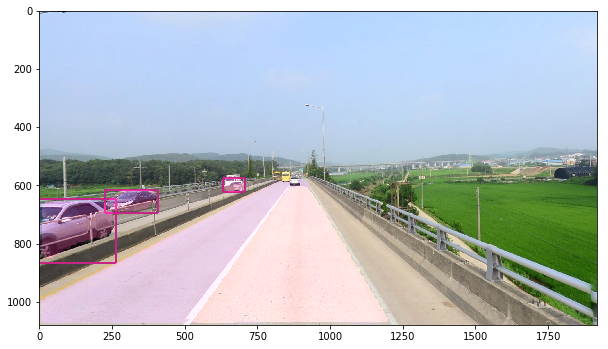

In [19]:
# 결과 시각화하기
idx = 1
image = sample_images[idx]
boxes = detection_outs[idx]
masks = instance_outs[idx]
segs = semantic_outs[idx]

plt.figure(figsize=(10,10))
vis = draw_instances(image, boxes, masks,
                     color_map=instance_colors, thickness=5)
vis = draw_semantics(vis, segs,
                     color_map=semantic_colors)
plt.imshow(vis)
plt.show()

# \[Evaluate Result \]
----


In [ ]:
batch_size = 2
semantic_labels = list(config.dataset.semantic_labels)
instance_labels = list(config.dataset.instance_labels)

result_df = pd.DataFrame(columns=['iou','counts'],
                         index=semantic_labels+instance_labels)
result_df[:] = 0
for idx in tqdm(range(len(validset)//batch_size)):
    # 데이터 가져오기
    targets = validset[idx*batch_size:(idx+1)*batch_size]
    images = targets['images']
    gt_detections = targets['detection']
    gt_semantics = targets['semantic']
    gt_instances = targets['instance']

    # 추론하기
    (pr_detections, pr_instances, pr_semantics) = model.predict(images)

    #####
    # Instance Segmentation을 평가
    #####
    for idx in range(batch_size):
        gt_detection = gt_detections[idx]
        pr_detection = pr_detections[idx]        
        gt_instance = gt_instances[idx]
        pr_instance = pr_instances[idx]
        gt_semantic = gt_semantics[idx]
        pr_semantic = pr_semantics[idx]
        
        image_h, image_w = image.shape[:2]
        masks = []
        for j, box in enumerate(pr_detection):
            if box[-1] <0:
                continue
            xmin = np.clip(box[0] - box[2] / 2, 0, image_w)
            xmax = np.clip(box[0] + box[2] / 2, 0, image_w)
            ymin = np.clip(box[1] - box[3] / 2, 0, image_h)
            ymax = np.clip(box[1] + box[3] / 2, 0, image_h)

            start = tuple(np.array((xmin, ymin), dtype=np.int32))
            end = tuple(np.array((xmax, ymax), dtype=np.int32))
            w = end[0] - start[0]
            h = end[1] - start[1]
            mask = cv2.resize(np.maximum(pr_instance[j], 0).astype(np.uint8),
                              (w, h))
            masks.append(np.pad(mask, 
                                ((start[1], image_h - end[1]),
                                 (start[0], image_w - end[0])),
                                'constant'))
        pr_instance = masks

        gt_area = (gt_detection[:,2] * gt_detection[:,3])
        pr_area = (pr_detection[:,2] * pr_detection[:,3])
        areas = gt_area[None, :] + pr_area[:, None]

        gt_norm_boxes = np.stack(
            (gt_detection[:,0] - gt_detection[:,2]/2,
             gt_detection[:,0] + gt_detection[:,2]/2,
             gt_detection[:,1] - gt_detection[:,3]/2,
             gt_detection[:,1] + gt_detection[:,3]/2),
            axis=1)
        pr_norm_boxes = np.stack(
            (pr_detection[:,0] - pr_detection[:,2]/2,
             pr_detection[:,0] + pr_detection[:,2]/2,
             pr_detection[:,1] - pr_detection[:,3]/2,
             pr_detection[:,1] + pr_detection[:,3]/2),
            axis=1)

        px1, px2, py1, py2 = np.transpose(pr_norm_boxes[:, None],(2,0,1))
        gx1, gx2, gy1, gy2 = np.transpose(gt_norm_boxes[None, :],(2,0,1))

        in_ymin = np.maximum(gy1, py1)
        in_xmin = np.maximum(gx1, px1)
        in_ymax = np.minimum(gy2, py2)
        in_xmax = np.minimum(gx2, px2)

        in_width = np.maximum(0., in_xmax - in_xmin)
        in_height = np.maximum(0., in_ymax - in_ymin)

        # 3. Calculate intersection size and union size
        intersection = in_width * in_height
        union = areas - intersection

        # 4. Masking if pred and gt's label is different
        iou = intersection / (union)
        iou = iou * np.equal(gt_detection[None,:,-2], 
                             pr_detection[:,None,-2])

        # 5. calculate iou
        for pr_i, gt_i in zip(*np.where(iou>0.5)):
            label = pr_detection[pr_i,-2]
            mask_intersect = np.logical_and(
                pr_instance[pr_i], gt_instance[gt_i])
            mask_union = np.logical_or(
                pr_instance[pr_i], gt_instance[gt_i])
            mask_iou = np.sum(mask_intersect) / np.sum(mask_union)
            result_df.loc[instance_labels[int(label)],"iou"] += mask_iou
            result_df.loc[instance_labels[int(label)],"counts"] += 1
            
    #######
    # Semantic Segmentation을 평가
    #######
    mask_intersect = np.logical_and(gt_semantic>0.5, pr_semantic>0.5)
    mask_union = np.logical_or(gt_semantic>0.5, pr_semantic>0.5)
    ious = (np.sum(mask_intersect,axis=(0,1)) / 
            (np.sum(mask_union,axis=(0,1)) + 1e-7))

    result_df.loc['other_road','iou'] += ious[0]
    result_df.loc['other_road','counts'] += 1

    result_df.loc['my_road','iou'] += ious[1]
    result_df.loc['my_road','counts'] += 1           

    if np.any(gt_instance[...,-1]!=-1):
        result_df.loc['crack','iou'] += ious[2]
        result_df.loc['crack','counts'] += 1
    result_df.loc[:,"miou"] = result_df.iou / (result_df.counts+1e-7)
    display(result_df)